In [10]:
import json
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict, Counter
from typing import Dict, List, Tuple, Optional, Any
import random
from functools import reduce, partial
from pathlib import Path

In [28]:
# ==================== DATA LOADING FUNCTIONS ====================


# ==================== STATISTICS FUNCTIONS ====================

def calculate_class_distribution(annotations: List[Dict], categories: Dict[int, Dict]) -> pd.DataFrame:
  """Calculate distribution of classes in annotations"""
  class_counts = Counter(
      categories[ann['category_id']]['name']
      for ann in annotations
  )

  df = pd.DataFrame(class_counts.items(), columns=['Class', 'Count'])
  df = df.sort_values('Count', ascending=False)
  df['Percentage'] = (df['Count'] / df['Count'].sum()) * 100
  df['Cumulative %'] = df['Percentage'].cumsum()

  return df

def calculate_bbox_statistics(annotations: List[Dict]) -> Dict:
  """Calculate bounding box statistics"""
  bboxes = [ann['bbox'] for ann in annotations]  # [x, y, width, height]

  widths = [bbox[2] for bbox in bboxes]
  heights = [bbox[3] for bbox in bboxes]
  areas = [bbox[2] * bbox[3] for bbox in bboxes]
  aspect_ratios = [bbox[2] / bbox[3] if bbox[3] > 0 else 0 for bbox in bboxes]

  def compute_stats(values: List[float], name: str) -> Dict:
      return {
          f'{name}_mean': np.mean(values),
          f'{name}_std': np.std(values),
          f'{name}_min': np.min(values),
          f'{name}_max': np.max(values),
          f'{name}_median': np.median(values),
          f'{name}_q25': np.percentile(values, 25),
          f'{name}_q75': np.percentile(values, 75)
      }

  return {
      **compute_stats(widths, 'width'),
      **compute_stats(heights, 'height'),
      **compute_stats(areas, 'area'),
      **compute_stats(aspect_ratios, 'aspect_ratio')
  }

def calculate_image_statistics(images: Dict, annotations_by_image: Dict) -> Dict:
      """Calculate image-level statistics"""
      ann_counts = [
          len(annotations_by_image.get(img_id, []))
          for img_id in images.keys()
      ]

      images_with_anns = sum(1 for count in ann_counts if count > 0)
      images_without_anns = len(images) - images_with_anns

      return {
          'total_images': len(images),
          'images_with_annotations': images_with_anns,
          'images_without_annotations': images_without_anns,
          'mean_annotations_per_image': np.mean(ann_counts),
          'std_annotations_per_image': np.std(ann_counts),
          'min_annotations_per_image': np.min(ann_counts),
          'max_annotations_per_image': np.max(ann_counts),
          'median_annotations_per_image': np.median(ann_counts)
      }

def calculate_class_imbalance_metrics(class_distribution: pd.DataFrame) -> Dict:
  """Calculate class imbalance metrics"""
  counts = class_distribution['Count'].values

  imbalance_ratio = counts.max() / counts.min() if counts.min() > 0 else np.inf

  # Identify rare and dominant classes (bottom/top 20%)
  n_classes = len(class_distribution)
  threshold = n_classes // 5

  rare_classes = class_distribution.tail(threshold)[['Class', 'Count']].to_dict('records')
  dominant_classes = class_distribution.head(threshold)[['Class',
'Count']].to_dict('records')

  # Check for long-tail distribution
  is_long_tail = np.std(counts) > np.mean(counts)

  return {
      'imbalance_ratio': imbalance_ratio,
      'rare_classes': rare_classes,
      'dominant_classes': dominant_classes,
      'is_long_tail': is_long_tail,
      'gini_coefficient': calculate_gini_coefficient(counts)
  }

def calculate_gini_coefficient(values: np.ndarray) -> float:
  """Calculate Gini coefficient for measuring inequality"""
  sorted_values = np.sort(values)
  n = len(values)
  cumsum = np.cumsum(sorted_values)
  return (2*np.sum((np.arange(1, n + 1))*sorted_values))/(n*cumsum[-1])-(n + 1)/n

  

# ==================== VISUALIZATION FUNCTIONS ====================

def plot_class_distribution(class_distribution: pd.DataFrame, save_path: Optional[str] = 
None):
  """Create comprehensive visualization of class distribution"""
  fig, axes = plt.subplots(2, 2, figsize=(15, 12))

  # 1. Bar plot of all classes (log scale)
  ax = axes[0, 0]
  ax.bar(range(len(class_distribution)), class_distribution['Count'].values)
  ax.set_xlabel('Class Index (sorted by frequency)')
  ax.set_ylabel('Number of Instances (log scale)')
  ax.set_title('Class Distribution Overview')
  ax.set_yscale('log')
  ax.grid(True, alpha=0.3)

  # 2. Top 10 classes
  ax = axes[0, 1]
  top_10 = class_distribution.head(10)
  ax.barh(top_10['Class'].values, top_10['Count'].values, color='green')
  ax.set_xlabel('Number of Instances')
  ax.set_title('Top 10 Most Frequent Classes')
  ax.invert_yaxis()

  # 3. Bottom 10 classes
  ax = axes[1, 0]
  bottom_10 = class_distribution.tail(10)
  ax.barh(bottom_10['Class'].values, bottom_10['Count'].values, color='red')
  ax.set_xlabel('Number of Instances')
  ax.set_title('Bottom 10 Least Frequent Classes')
  ax.invert_yaxis()

  # 4. Cumulative distribution
  ax = axes[1, 1]
  ax.plot(range(len(class_distribution)),
          class_distribution['Cumulative %'].values,
          linewidth=2, color='blue')
  ax.fill_between(range(len(class_distribution)),
                   class_distribution['Cumulative %'].values,
                   alpha=0.3)
  ax.set_xlabel('Number of Classes')
  ax.set_ylabel('Cumulative Percentage (%)')
  ax.set_title('Cumulative Distribution of Instances')
  ax.grid(True, alpha=0.3)
  ax.axhline(y=80, color='r', linestyle='--', alpha=0.5, label='80% threshold')
  ax.legend()

  plt.tight_layout()
  if save_path:
      plt.savefig(save_path, dpi=300, bbox_inches='tight')
  plt.show()





  # ==================== UTILITY FUNCTIONS ====================

def get_images_for_class(
  class_name: str,
  annotations: List[Dict],
  categories: Dict[int, Dict],
  images: Dict[int, Dict],
  max_images: int = 10
) -> List[str]:
  """Get list of image filenames containing specific class"""
  # Find category id for class name
  cat_id = next((cid for cid, cat in categories.items()
                 if cat['name'] == class_name), None)

  if cat_id is None:
      return []

  # Find unique image ids with this class
  image_ids = list(set(
      ann['image_id'] for ann in annotations
      if ann['category_id'] == cat_id
  ))[:max_images]

  return [images[img_id]['file_name'] for img_id in image_ids]

def filter_annotations_by_size(
  annotations: List[Dict],
  min_area: Optional[float] = None,
  max_area: Optional[float] = None
) -> List[Dict]:
  """Filter annotations by bounding box area"""
  def check_size(ann):
      area = ann['bbox'][2] * ann['bbox'][3]
      if min_area and area < min_area:
          return False
      if max_area and area > max_area:
          return False
      return True

  return list(filter(check_size, annotations))

def generate_summary_report(
  coco_data: Dict,
  images_dir: str,
  output_path: str = 'data_audit/data_summary.md'
) -> str:
  """Generate comprehensive data summary report"""
  # Parse data
  categories = parse_categories(coco_data)
  images = parse_images(coco_data)
  annotations_by_image = parse_annotations_by_image(coco_data)

  # Calculate statistics
  class_dist = calculate_class_distribution(coco_data['annotations'], categories)
  bbox_stats = calculate_bbox_statistics(coco_data['annotations'])
  img_stats = calculate_image_statistics(images, annotations_by_image)
  imbalance_metrics = calculate_class_imbalance_metrics(class_dist)

  # Generate report
  report = f"""# Data Summary Report

## Dataset Overview
- **Total Images**: {img_stats['total_images']}
- **Total Annotations**: {len(coco_data['annotations'])}
- **Total Classes**: {len(categories)}
- **Images with Annotations**: {img_stats['images_with_annotations']}
- **Images without Annotations**: {img_stats['images_without_annotations']}

## Annotation Statistics
- **Mean Annotations per Image**: {img_stats['mean_annotations_per_image']:.2f}
- **Std Annotations per Image**: {img_stats['std_annotations_per_image']:.2f}
- **Min/Max Annotations**: {img_stats['min_annotations_per_image']:.0f} / 
{img_stats['max_annotations_per_image']:.0f}

## Class Imbalance Metrics
- **Imbalance Ratio**: {imbalance_metrics['imbalance_ratio']:.2f}
- **Gini Coefficient**: {imbalance_metrics['gini_coefficient']:.3f}
- **Long-tail Distribution**: {'Yes' if imbalance_metrics['is_long_tail'] else 'No'}



## Top 5 Classes
{class_dist.head(5).to_markdown(index=False)}

## Bottom 5 Classes
{class_dist.tail(5).to_markdown(index=False)}
"""

  with open(output_path, 'w') as f:
      f.write(report)

  return report

# ==================== MAIN EXECUTION FUNCTION ====================

def run_initial_data_analysis(
  annotation_path: str = '/workspace/some_exp/genus/hald_assignment/StudyCase/_annotations.coco.json',
  images_dir: str = 'workspace/some_exp/genus/hald_assignment/StudyCase/images',
  output_dir: str = 'data_audit'
):
  """Run complete initial data analysis"""
  print("Loading COCO annotations...")
  coco_data = load_coco_annotations(annotation_path)

  print("Parsing data structures...")
  categories = parse_categories(coco_data)
  images = parse_images(coco_data)
  annotations_by_image = parse_annotations_by_image(coco_data)

  print(f"Found {len(categories)} categories, {len(images)} images,{len(coco_data['annotations'])} annotations")

  print("\nCalculating class distribution...")
  class_dist = calculate_class_distribution(coco_data['annotations'], categories)

  

  print("\nGenerating visualizations...")
  os.makedirs(output_dir, exist_ok=True)
  plot_class_distribution(class_dist, f"{output_dir}/class_distribution.png")

  print("\nGenerating summary report...")
  report = generate_summary_report(coco_data, images_dir, f"{output_dir}/data_summary.md")

  print(f"\nAnalysis complete! Check {output_dir}/ for results.")

  return {
      'coco_data': coco_data,
      'categories': categories,
      'images': images,
      'annotations_by_image': annotations_by_image,
      'class_distribution': class_dist,
  }


  

In [20]:

def load_coco_annotations(annotation_path: str) -> Dict:
  """Load COCO format annotations from JSON file"""
  with open(annotation_path, 'r') as f:
      return json.load(f)

def parse_categories(coco_data: Dict) -> Dict[int, Dict]:
  """Extract category id to name/supercategory mapping"""
  return {
      cat['id']: {
          'name': cat['name'],
          'supercategory': cat.get('supercategory', 'plankton')
      }
      for cat in coco_data['categories']
  }

def parse_images(coco_data: Dict) -> Dict[int, Dict]:
  """Extract image id to image info mapping"""
  return {
      img['id']: {
          'file_name': img['file_name'],
          'height': img['height'],
          'width': img['width'],
          'id': img['id']
      }
      for img in coco_data['images']
  }

def parse_annotations_by_image(coco_data: Dict) -> Dict[int, List]:
  """Group annotations by image id"""
  annotations = defaultdict(list)
  for ann in coco_data['annotations']:
      annotations[ann['image_id']].append(ann)
  return dict(annotations)

def parse_annotations_by_category(coco_data: Dict) -> Dict[int, List]:
  """Group annotations by category id"""
  annotations = defaultdict(list)
  for ann in coco_data['annotations']:
      annotations[ann['category_id']].append(ann)
  return dict(annotations)


annotation_path = '/workspace/some_exp/genus/hald_assignment/StudyCase/_annotations.coco.json'
images_dir  = 'workspace/some_exp/genus/hald_assignment/StudyCase/images'




In [23]:
coco_data = load_coco_annotations(annotation_path)
categories = parse_categories(coco_data)
# categories

In [24]:
images = parse_images(coco_data)
# images

In [26]:
annotations_by_image = parse_annotations_by_image(coco_data)
# annotations_by_image

In [27]:
print(f"Found {len(categories)} categories, {len(images)} images,{len(coco_data['annotations'])} annotations")

Found 39 categories, 451 images,5050 annotations


Loading COCO annotations...
Parsing data structures...
Found 39 categories, 451 images,5050 annotations

Calculating class distribution...

Generating visualizations...


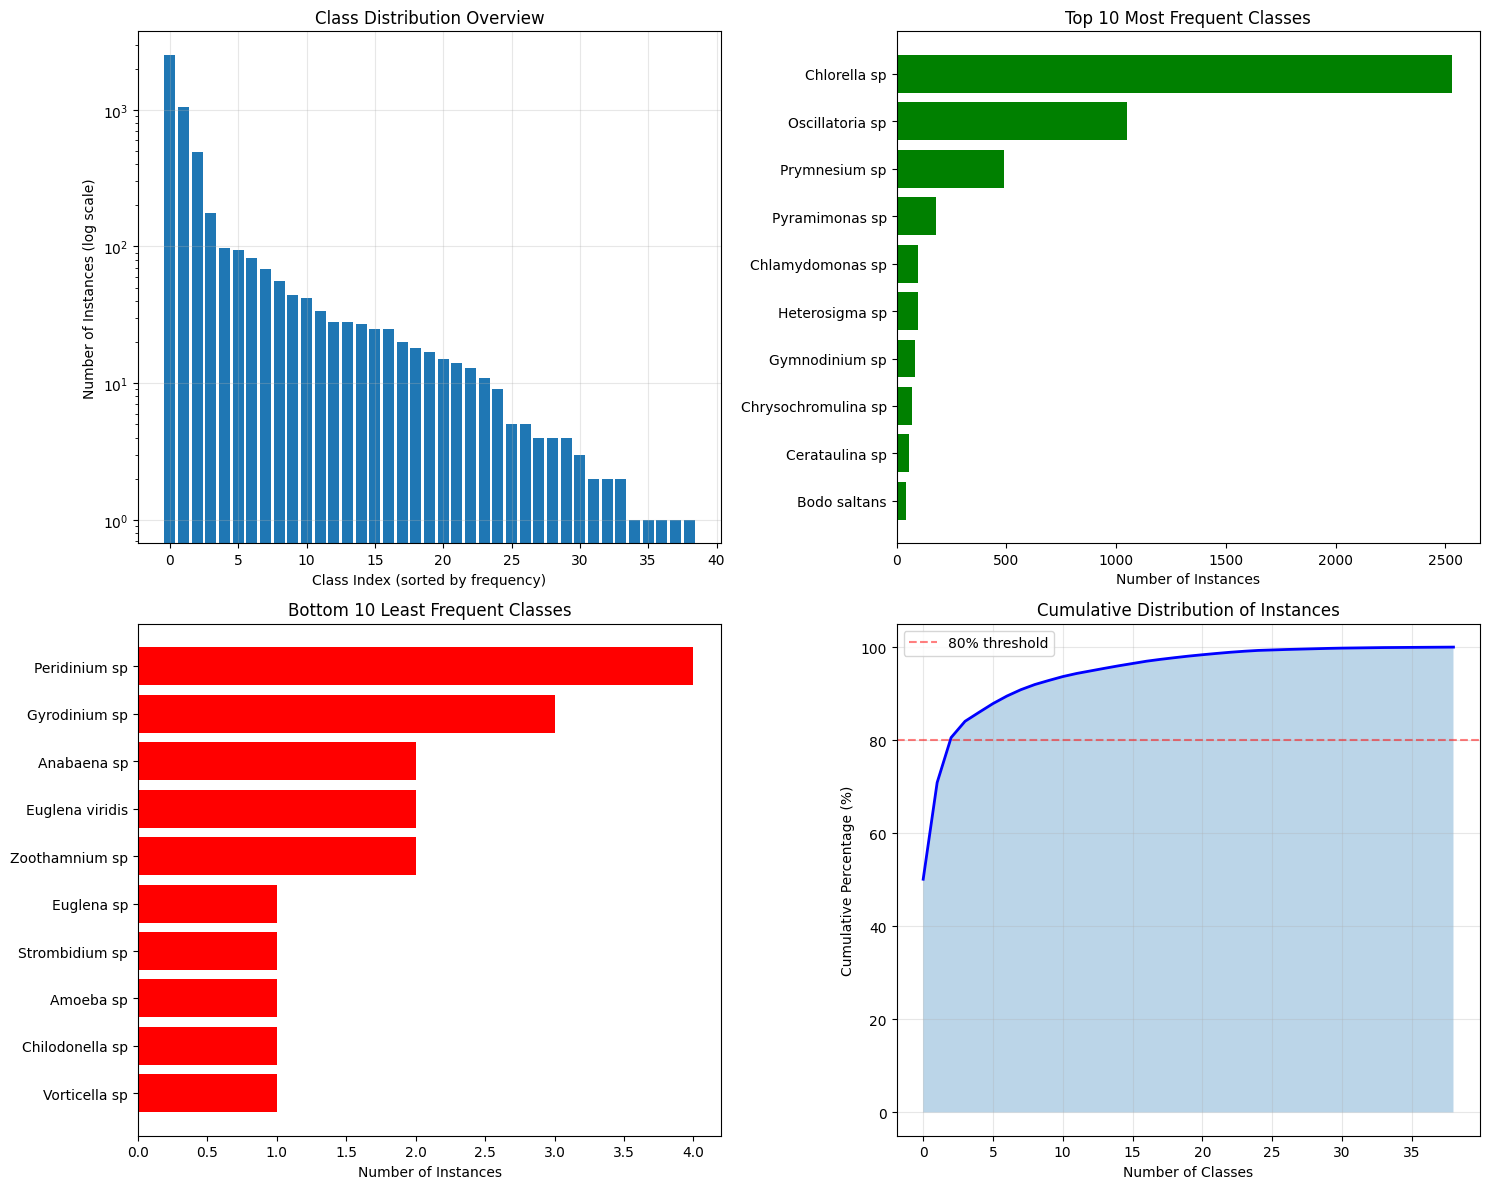


Generating summary report...

Analysis complete! Check data_audit/ for results.


In [29]:
results = run_initial_data_analysis()